In [10]:
#python libraries
import pandas as pd
import numpy as np
import os

#import visulazitions
import matplotlib.pyplot as plt
import seaborn as sns

#import files
from env import get_connection
import wrangle as w
#import scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#Import for modeling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# imporrt for scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler,QuantileTransformer

#import for feature selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE


In [11]:
def new_zillow_data():
    """
    This function will:
    - create a connect_url to mySQL
    - return a df of the given query from the zillow db
    """
    url = get_connection('zillow')
    SQL_query = '''
                select bedroomcnt as bedrooms, bathroomcnt as bathrooms, calculatedfinishedsquarefeet as sqft
                     , taxvaluedollarcnt as property_value, yearbuilt as year_built, fips as county,
                     CAST(latitude / 1e6 AS DECIMAL(10, 6)) AS latitude_dd,
                    CAST(longitude / 1e6 AS DECIMAL(10, 6)) AS longitude_dd
                from properties_2017
                join predictions_2017 using(parcelid)
                where propertylandusetypeid = 261
                '''
    return pd.read_sql(SQL_query, url)

In [12]:
df = new_zillow_data()

In [13]:
df.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county,latitude_dd,longitude_dd
0,4.0,3.5,3100.0,1023282.0,1998.0,6059.0,33.634931,-117.869207
1,2.0,1.0,1465.0,464000.0,1967.0,6111.0,34.449266,-119.281531
2,3.0,2.0,1243.0,564778.0,1962.0,6059.0,33.886168,-117.823170
3,4.0,3.0,2376.0,145143.0,1970.0,6037.0,34.245180,-118.240722
4,4.0,3.0,2962.0,773303.0,1950.0,6037.0,34.145202,-118.179824


In [14]:
df.shape

(52442, 8)

In [15]:
#create a function to visualize whats in the dataset

def check_columns(df):
    """
    This function takes a pandas dataframe as input and returns
    a dataframe with information about each column in the dataframe. For
    each column, it returns the column name, the number of
    unique values in the column, the unique values themselves,
    the number of null values in the column, and the data type of the column.
    The resulting dataframe is sorted by the 'Number of Unique Values' column in ascending order.
​
    Args:
    - df: pandas dataframe
​
    Returns:
    - pandas dataframe
    """
    data = []
    # Loop through each column in the dataframe
    for column in df.columns:
        # Append the column name, number of unique values, unique values, number of null values, and data type to the data list
        data.append(
            [
                column,
                df[column].nunique(),
                df[column].unique(),
                df[column].isna().sum(),
                df[column].isna().mean(),
                df[column].dtype
            ]
        )
    # Create a pandas dataframe from the data list, with column names 'Column Name', 'Number of Unique Values', 'Unique Values', 'Number of Null Values', and 'dtype'
    # Sort the resulting dataframe by the 'Number of Unique Values' column in ascending order
    return pd.DataFrame(
        data,
        columns=[
            "Column Name",
            "Number of Unique Values",
            "Unique Values",
    "Number of Null Values",
            "Proportion of Null Values",
            "dtype"
        ],
    ).sort_values(by="Number of Unique Values")

In [17]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
5,county,3,"[6059.0, 6111.0, 6037.0]",0,0.000000,float64
0,bedrooms,14,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 0.0, 8.0, ...",0,0.000000,float64
1,bathrooms,22,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,year_built,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",116,0.002212,float64
2,sqft,4723,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",82,0.001564,float64
3,property_value,38942,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64
6,latitude_dd,50478,"[33.634931, 34.449266, 33.886168, 34.24518, 34...",0,0.000000,float64
7,longitude_dd,50764,"[-117.869207, -119.281531, -117.82317, -118.24...",0,0.000000,float64


change unique values to (6037: 'LA', 6059: 'Orange', 6111: 'Ventura')


In [18]:
# start with county, change unique values
df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

In [19]:
df.county.head()

0     Orange
1    Ventura
2     Orange
3         LA
4         LA
Name: county, dtype: object

In [20]:
df.bedrooms = df.bedrooms.astype(int)


In [21]:
df.bedrooms[df['bedrooms'] <= 8]


0        4
1        2
2        3
3        4
4        4
        ..
52437    2
52438    4
52439    3
52440    3
52441    3
Name: bedrooms, Length: 52427, dtype: int64

In [22]:
df.drop(df[df['bedrooms'] > 8].index, inplace=True)


In [23]:
df.bedrooms.value_counts()


bedrooms
3    23360
4    15240
2     8340
5     3973
6      635
1      612
0      137
7      106
8       24
Name: count, dtype: int64

In [24]:
df.drop(df[df['bedrooms'] == 0].index, inplace=True)


In [25]:
df.bedrooms.value_counts()


bedrooms
3    23360
4    15240
2     8340
5     3973
6      635
1      612
7      106
8       24
Name: count, dtype: int64

garage_fits:
65% nan (Assume they have No Garage?)

In [28]:
# take care of null vals for yearbuilt, finished_area, lot_area, and home_value
df = df.dropna()

In [29]:
check_columns(df)


,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
5,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.0,float64
4,year_built,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",0,0.0,float64
2,sqft,4700,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
3,property_value,38794,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64
6,latitude_dd,50323,"[33.634931, 34.449266, 33.886168, 34.24518, 34...",0,0.0,float64
7,longitude_dd,50603,"[-117.869207, -119.281531, -117.82317, -118.24...",0,0.0,float64


In [30]:
df.shape


(52248, 8)

In [36]:
train, validate, test = w.split_function(df)


In [37]:
train.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county,latitude_dd,longitude_dd
21100,5,3.0,3350.0,902914.0,1980.0,Orange,33.840924,-117.786551
35297,5,3.0,2286.0,564000.0,1962.0,Orange,33.819304,-118.000192
44391,4,3.0,2611.0,565000.0,1998.0,LA,34.471132,-118.628501
36041,3,1.5,1000.0,339941.0,1955.0,Orange,33.764253,-117.929498
18994,4,3.0,2824.0,644683.0,1979.0,LA,34.376623,-118.541723


In [40]:
columns = train.drop(columns='county').columns


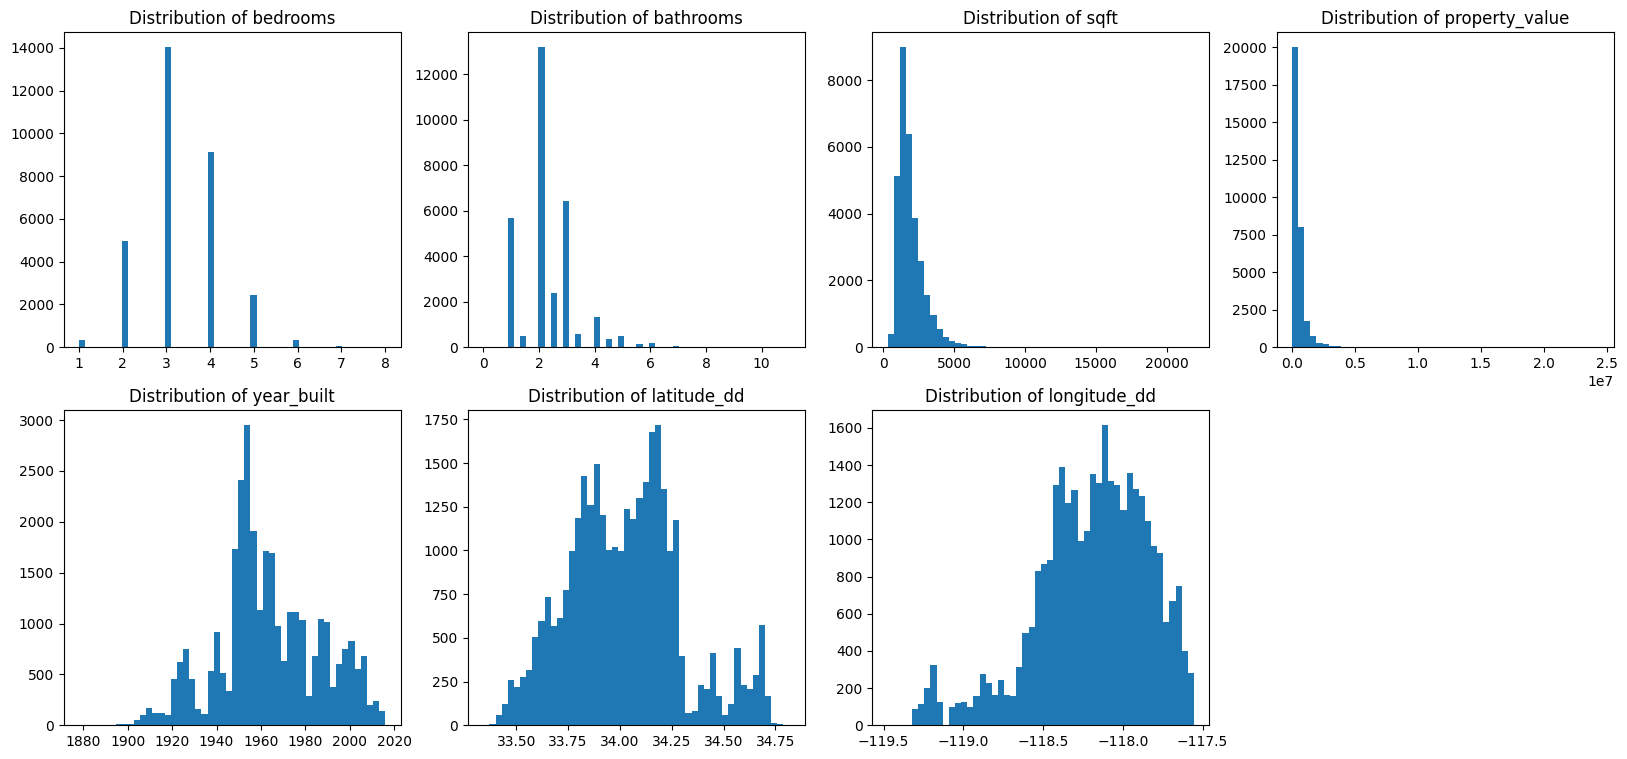

In [41]:
# visualize univariate distributions:
plt.figure(figsize=(20,9))
for i, col in enumerate(columns):
    subplot_num = i+1
    plt.subplot(2,4,subplot_num)
    plt.title(f'Distribution of {col}')
    train[col].hist(bins=50)
    plt.grid(False)
plt.show()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


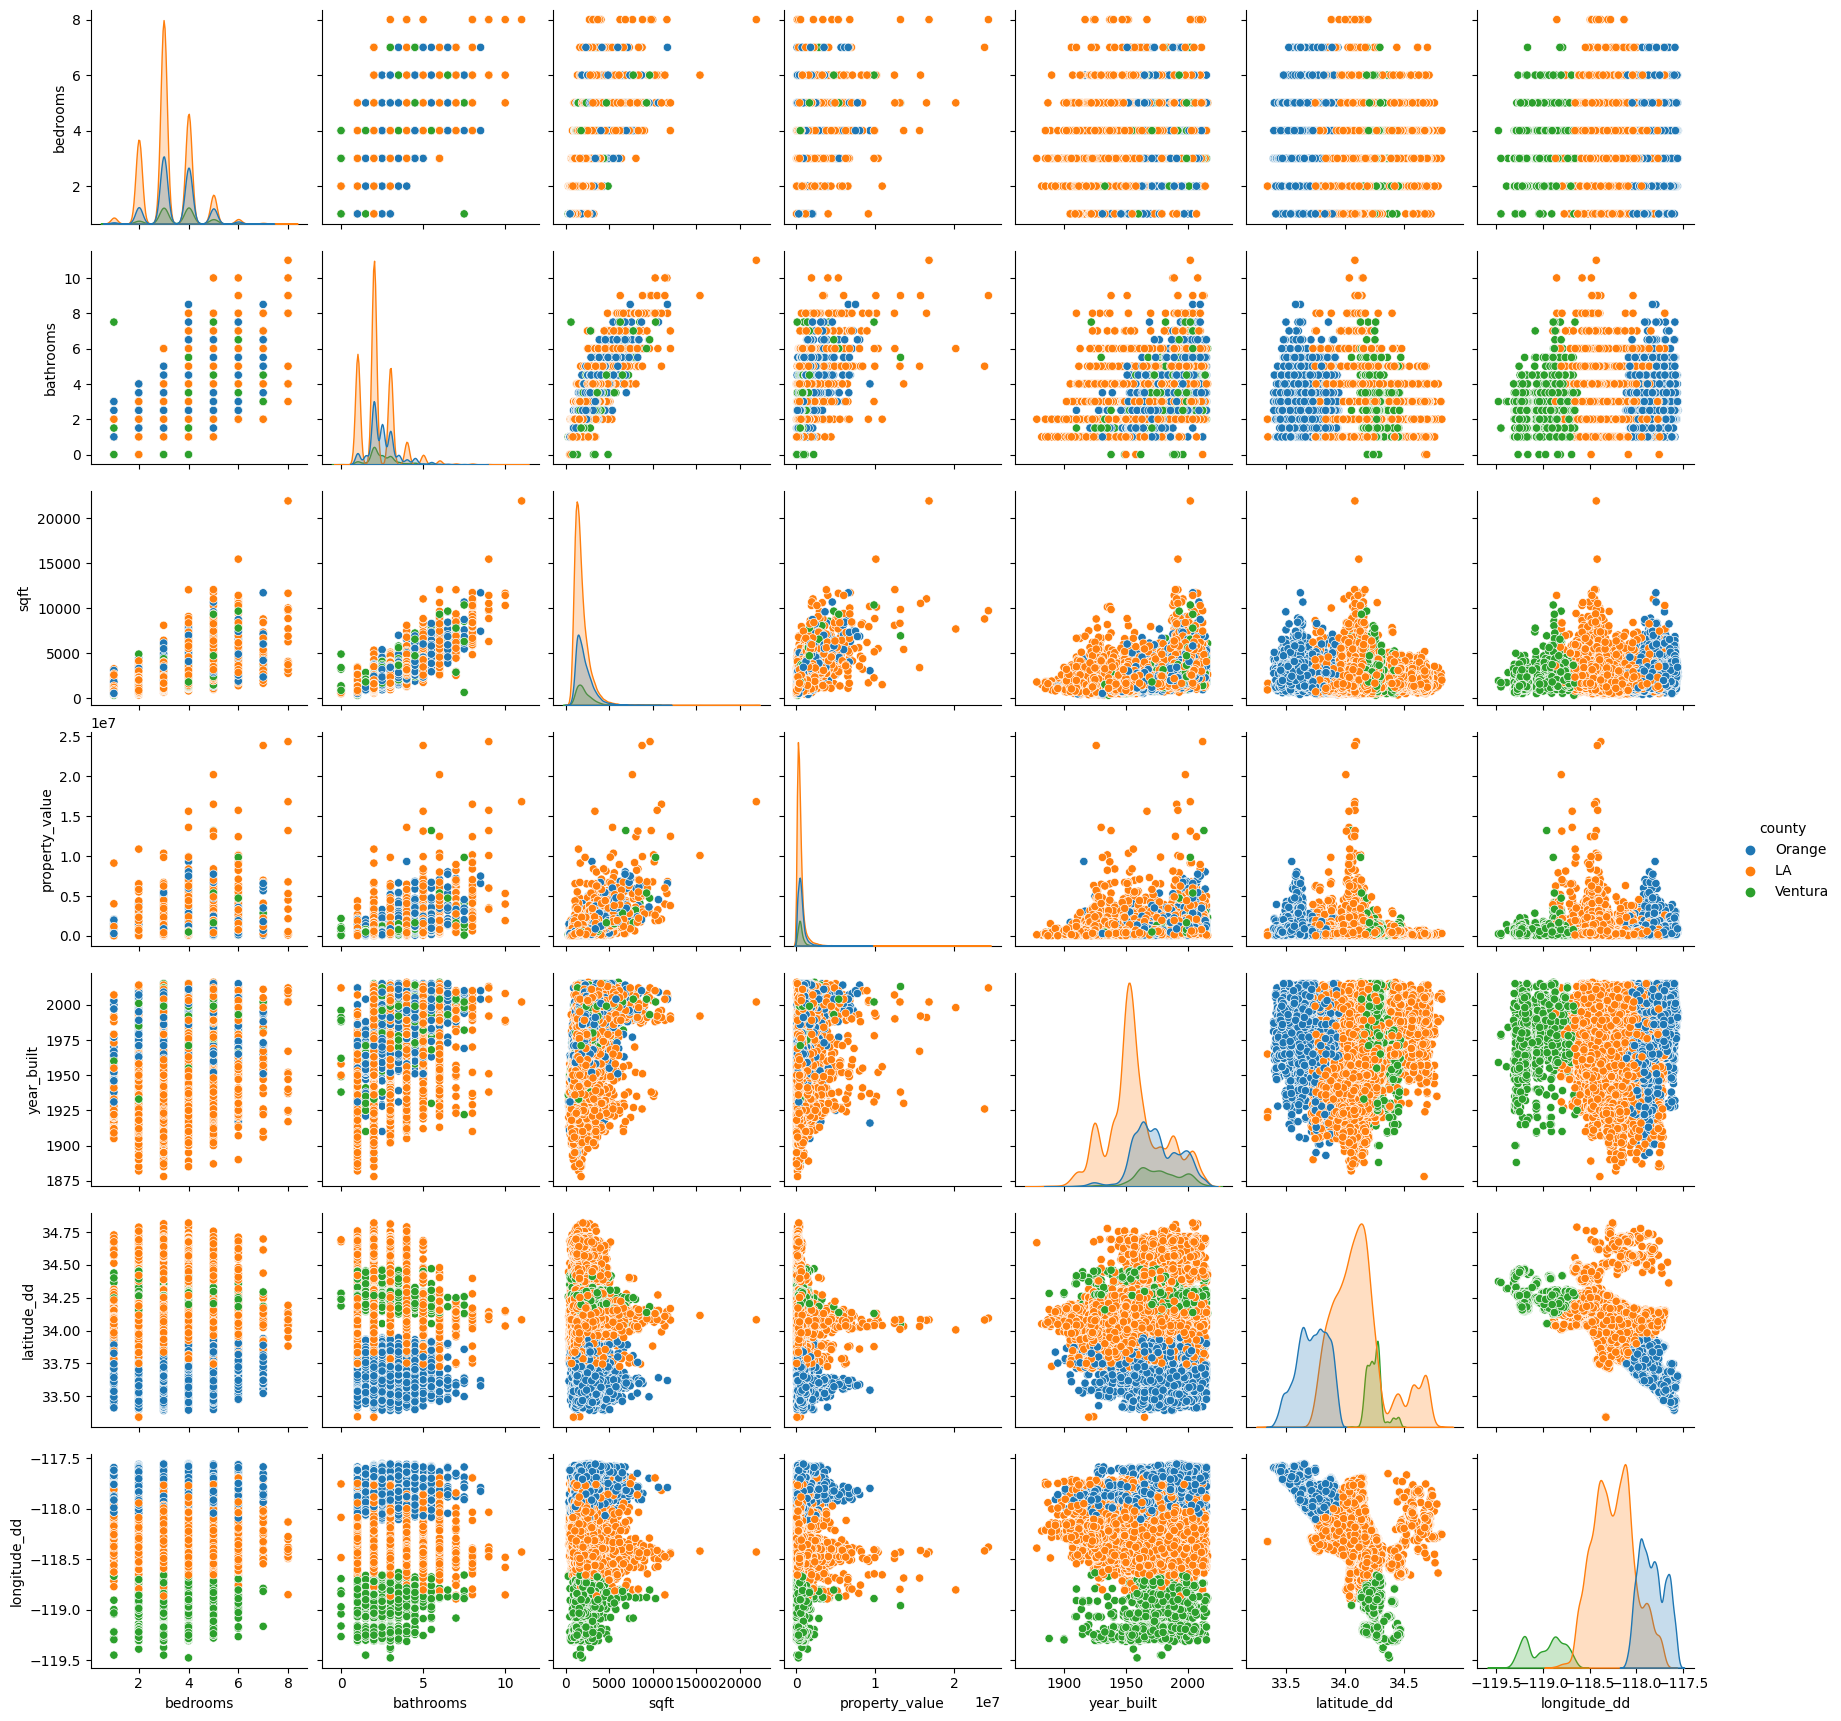

In [43]:
sns.pairplot(train, hue='county')


# Why do some properties have a much higher value than others when they are located so close to each other?